[실습] 신용 카드 고객 데이터 분석과 신용도 예측

### 데이터 분석 목적
    - 신용카드 발급을 희망하는 소비자 데이터를 분석하고 카드 발급 여부 결정을 위한 의사 결정 모델을 분석한다.
    - 신용불량자를 판별하여 신용카드 비즈니스 영업 이익률을 개선시킨다.

   
### Key Point
    - 데이터 처리(join, target label 선정) 방법에 대해 배운다
    - 데이터 유형별 EDA와 insight를 얻는 방법에 대해 배운다
    - categorical data 결측치를 처리하는 방법을 배운다
    - 모델 최적화하는 방법을 배우고 최종 모델을 선정할 때 고려해야 하는 metric에 대해 배운다.



In [1]:
!pip install shap

In [ ]:
!pip install sklearn-pandas==1.5.0
# 설치하실 때 꼭 sklearn-pandas 1.5.0 버전을 설치해주셔야 합니다.
# 위 버전이 아닐 경우, 문제될 수 있습니다. 유의해주시길 바랍니다.

In [1]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
#import pandas_profiling
from datetime import datetime
import random

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
from scipy.stats import boxcox, norm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols
#import sklearn_pandas
#from sklearn_pandas import DataFrameMapper, CategoricalImputer

# library for sampling
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

# library for machine learning
import sklearn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import shap
%matplotlib inline

## 1. Data Processing 1

### 1-1 Data Load

In [2]:
!pwd
path_lecture = "./"
random_state = 1234

/Users/stayfoolish/Desktop/FastCampus/강의자료/CH06/실습자료/credit_approval_prediction


In [3]:
df = pd.read_csv(path_lecture + "data/application_record.csv")
df_record = pd.read_csv(path_lecture + "data/credit_record.csv")
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
df_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
df_record.sort_values(["ID", "MONTHS_BALANCE"], ascending=False).groupby("ID").first()

,MONTHS_BALANCE,STATUS
ID,,
5001711,0,X
5001712,0,C
5001713,0,X
5001714,0,X
5001715,0,X
...,...,...
5150482,-11,C
5150483,0,X
5150484,0,C


### 1-2 Duplicated Data 확인

1. 데이터를 내가 수집
2. 남의 데이터 활용

In [6]:
print("중복된 항목 수 :", len(df[df.duplicated()]))
print("중복된 항목 수 :", len(df_record[df_record.duplicated()]))

중복된 항목 수 : 0
중복된 항목 수 : 0


### 1-3 Data Join

In [7]:
len(df)

438557

In [8]:
df.merge(df_record, on="ID", how="inner").head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


In [9]:
len(df.merge(df_record, on="ID", how="inner"))

777715

In [10]:
# df는 438557인데, join후에 777715 개가 됨 -> df_record에 ID별 data가 1개 이상인 경우가 있음을 의미
print(len(df_record))
print(df_record.ID.nunique())

1048575
45985


In [11]:
# df_record에서 가장 최근 데이터 만을 선택. 0이 현재며 -1일때마다 1달씩 과거 시점의 데이터.
# -1은 한 달전 데이터, -10은 10개월전 데이터
df_record.MONTHS_BALANCE.unique()

array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
       -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25,
       -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38,
       -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51,
       -52, -53, -54, -55, -56, -57, -58, -59, -60])

In [12]:
# ID별 가장 최신의 데이터만 선택
df_record_filtered = df_record.sort_values(["ID", "MONTHS_BALANCE"], ascending=False).groupby("ID").first()
df_record_filtered

,MONTHS_BALANCE,STATUS
ID,,
5001711,0,X
5001712,0,C
5001713,0,X
5001714,0,X
5001715,0,X
...,...,...
5150482,-11,C
5150483,0,X
5150484,0,C


In [13]:
# target 데이터가 없는 데이터들은 학습할 수 없으므로 제거 -> join을 활용해서 제거할 수 있음
# semi-supervised learning이라는 기법이 있어, target 데이터가 없는 데이터를 같이 활용할 수 있는 방법이 있음 -> 하지만, 이번 강의에서는 다루지 않기 때문에 skip
df = df.merge(df_record_filtered, on="ID", how="inner")

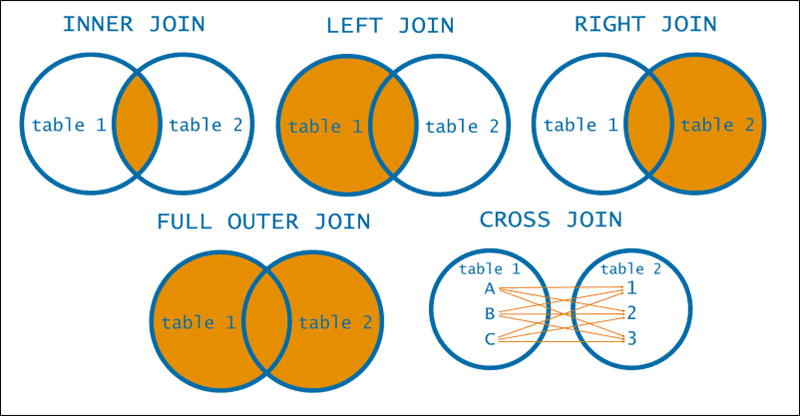

In [15]:
Image(path_lecture+"img/jointypes.png")

### 1-4 Dependent(종속) Data 선정
*   본 데이터의 Target은 의사 결정권자가 선택이 필요함
*   어느 정도의 신용 STATUS에 대해서 신용카드 발급 승인을 내릴 지를 검토 필요
*   **본 실습에서는 연체가 없는 고객들에 대해서만 신용카드 발급 승인을 내려주는 것으로 데이터 분석 진행**



In [14]:
df.STATUS.unique()

array(['C', '0', 'X', '1', '5', '3', '4', '2'], dtype=object)

In [15]:
condition_no_approval = df.STATUS.isin(["0","1","2","3","4","5"])
df["Target_Status"] = None
df.loc[condition_no_approval,"Target_Status"] = 0
df.loc[~condition_no_approval, "Target_Status"] = 1

In [16]:
df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Target_Status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,0,C,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,0,C,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,0,C,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,0,0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-22,X,1


In [17]:
# 기존 STATUS 제거
df = df.drop("STATUS", axis=1)

## 2. Data EDA

### 2-1 Data Type and Summary

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [19]:
df.isna().sum().sort_values(ascending=False)

OCCUPATION_TYPE        11323
ID                         0
CODE_GENDER                0
MONTHS_BALANCE             0
CNT_FAM_MEMBERS            0
FLAG_EMAIL                 0
FLAG_PHONE                 0
FLAG_WORK_PHONE            0
FLAG_MOBIL                 0
DAYS_EMPLOYED              0
DAYS_BIRTH                 0
NAME_HOUSING_TYPE          0
NAME_FAMILY_STATUS         0
NAME_EDUCATION_TYPE        0
NAME_INCOME_TYPE           0
AMT_INCOME_TOTAL           0
CNT_CHILDREN               0
FLAG_OWN_REALTY            0
FLAG_OWN_CAR               0
Target_Status              0
dtype: int64

In [20]:
# categorical and numeric columns
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

ID int64 [5008804 5008805 5008806 ... 5149838 5150049 5150337]
CODE_GENDER object ['M' 'F']
FLAG_OWN_CAR object ['Y' 'N']
FLAG_OWN_REALTY object ['Y' 'N']
CNT_CHILDREN int64 [ 0  1  3  2  4  5 14 19  7]
AMT_INCOME_TOTAL float64 [ 427500.   112500.   270000.   283500.   135000.   130500.   157500.
  405000.   211500.   360000.   126000.   315000.   247500.   297000.
  225000.   166500.   216000.   255150.   148500.   202500.    94500.
  450000.   180000.    90000.   765000.   382500.   144000.   229500.
  292500.    74250.    40500.   337500.   193500.   267750.   139500.
   67500.   252000.   900000.   115290.   279000.    76500.   234000.
   81000.   108000.    99000.   198000.    45000.   238500.   117000.
  153000.  1350000.   445500.   495000.    85500.   306000.   562500.
  189000.   328500.   310500.   540000.   171000.   675000.   121500.
   72000.    65250.   184500.   103500.   162000.   165150.    54000.
  243000.   256500.    33300.   697500.   101250.    58500.   110250.
  

In [21]:
list_cast_object = ["ID", "FLAG_MOBIL", "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL"]
for column_name in list_cast_object:
  df[column_name] = df[column_name].astype(object)

In [22]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64','int64']).columns)
target_column = "Target_Status"
print(len(df))
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

36457
20
14
6


#### Summary of Data Set
##### - Number of Variables : 20
    numeric variables : 6
    categorical variables : 14 (target 포함)
##### - Number of observations : 36457
##### - Missing Cells : 1 columns (OCCUPATION_TYPE)
##### - Duplicated Rows : 0

### 2-2 Dependent(종속) Data Explore

In [23]:
##### to do #####
# list_cateogircal에서 target_column제거
list_categorical_columns.remove(target_column)

In [24]:
##### to do #####
df[target_column].describe()

count     36457
unique        2
top           1
freq      27619
Name: Target_Status, dtype: int64

<AxesSubplot: xlabel='Target_Status', ylabel='count'>

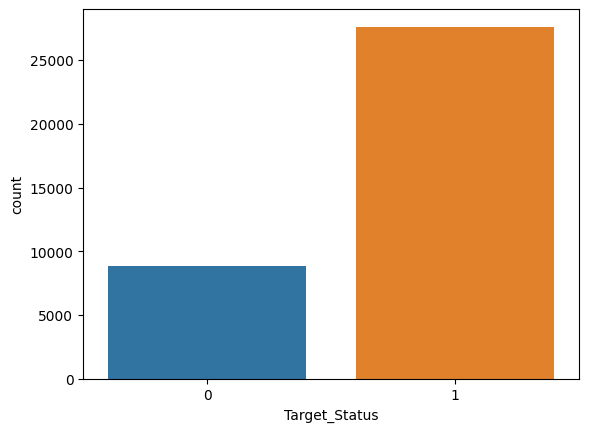

In [25]:
##### to do #####
sns.countplot(x=target_column, data=df)

#### Imbalance data set?
  - 두 개 target class 비중 차이가 있다. 독립 변수가 categorical 이 포함된 경우는 one-hot encoding을 진행한 뒤에 sampling(oversampling 혹은 undersampling) 을 해야 한다.
  - 1 속성인 데이터들이 유의미한 데이터 분포와 특성을 갖는다면, 추가적인 sampling 없이 모델 학습이 잘 될 수 있다.
  - ML 학습시 cost-sensitive (class weight 등)을 활용할 수 있다.

##### 1. 데이터 기반 접근 방법
    - Sampling (over sampling)
    (이번 실습에서는 oversampling sampling 중에서 SMOTE 활용)
    https://imbalanced-learn.org/stable/references/index.html#api
##### 2. ML 알고리즘 기반 접근 방법
    - ML 알고리즘 활용 -> ML 학습 시에 class weight를 활용하여 cost-sensitive learning
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 2-3 Independent(독립) Data Explore

#### 1) Categorical Data Analysis

##### 불필요한 컬럼 확인

In [26]:
df[list_categorical_columns].nunique().sort_values()

FLAG_MOBIL                 1
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
OCCUPATION_TYPE           18
ID                     36457
dtype: int64

In [27]:
# FLAG_MOBIL은 1개 값만 갖기 때문에 제거
# ID는 불필요하므로 제거

##### to do #####
df = df.drop(["ID", "FLAG_MOBIL"], axis=1)

In [28]:
list_categorical_columns.remove("ID")
list_categorical_columns.remove("FLAG_MOBIL")

##### Column별 분포 확인

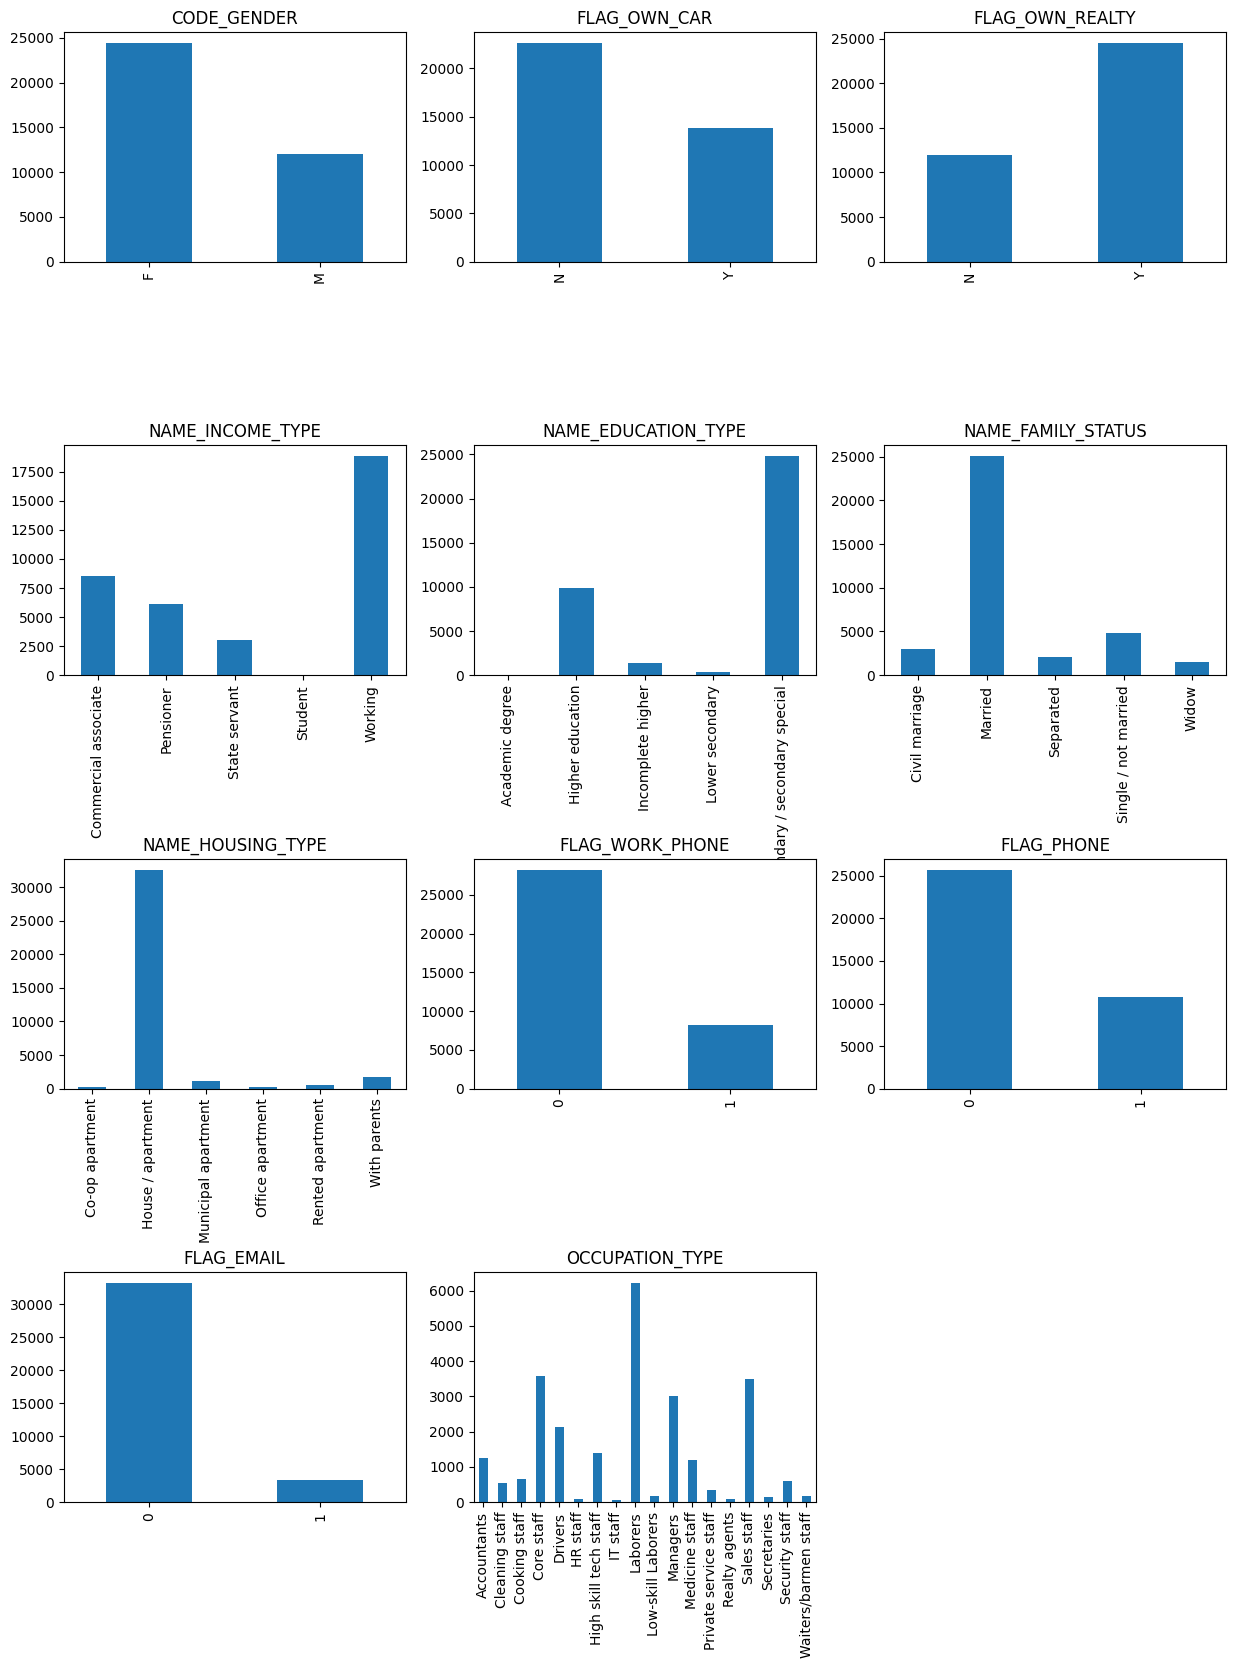

In [29]:
# cateogircla column 별 분포 확인
plt.figure(figsize=(15,15))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_columns:
    plt.subplot(4,3,x)
    x = x+1
    df[column_name].value_counts().sort_index().plot(kind='bar')
    plt.title(column_name)
plt.show()

##### Target column과 categorical column 관계 분포 확인

<AxesSubplot: xlabel='CODE_GENDER'>

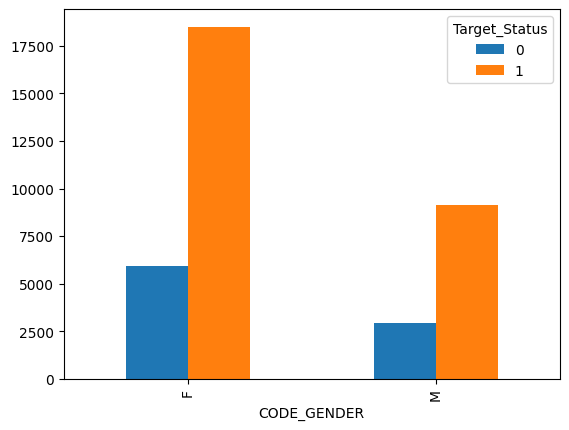

In [30]:
# categorical column과 dependent data(target column) 분포 분석
df_poutcome_dependent = pd.crosstab(df[list_categorical_columns[0]],df[target_column])
df_poutcome_dependent.plot(kind='bar')
# 애초에 target_column(Target_Status) 비중이 다르기 때문에, 아래와 같이 count 수를 비교하는 것은 데이터 분포를 파악하는데 적합하지 않음

In [31]:
##### to do #####
pd.crosstab(df[list_categorical_columns[0]], df[target_column] , normalize="index")

Target_Status,0,1
CODE_GENDER,,
F,0.242448,0.757552
M,0.242371,0.757629


<AxesSubplot: xlabel='CODE_GENDER'>

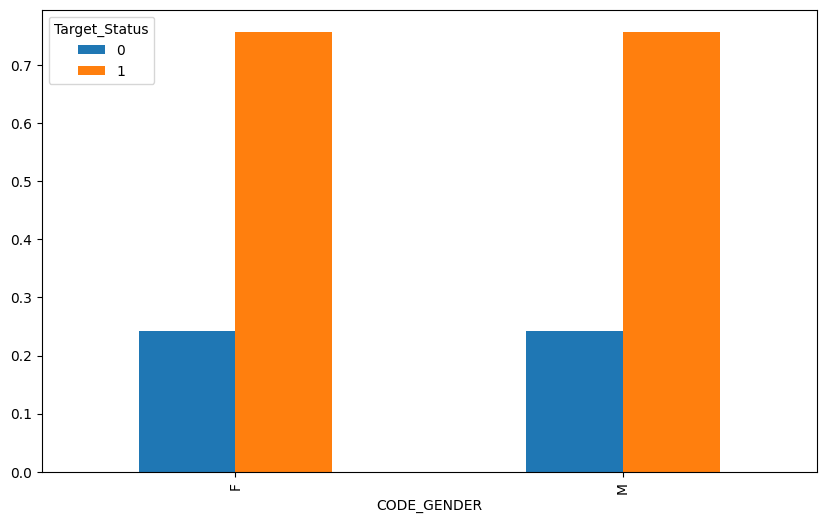

In [32]:
##### to do #####
# 성별은 Target_Status와 상관관계가 없어 보인다.
df_poutcome_dependent_ratio = pd.crosstab(df[list_categorical_columns[0]], df[target_column] , normalize="index")
df_poutcome_dependent_ratio.plot.bar(figsize=(10,6))

<Figure size 3000x3000 with 0 Axes>

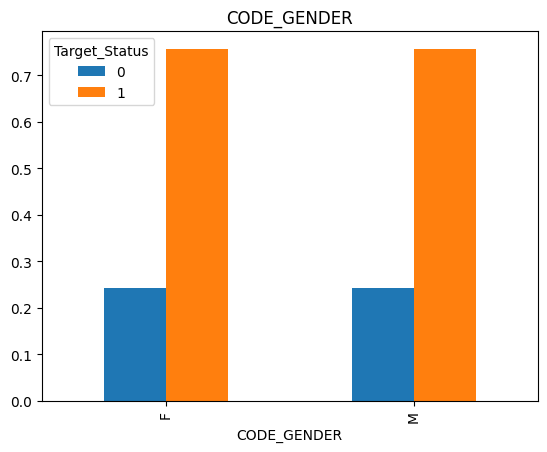

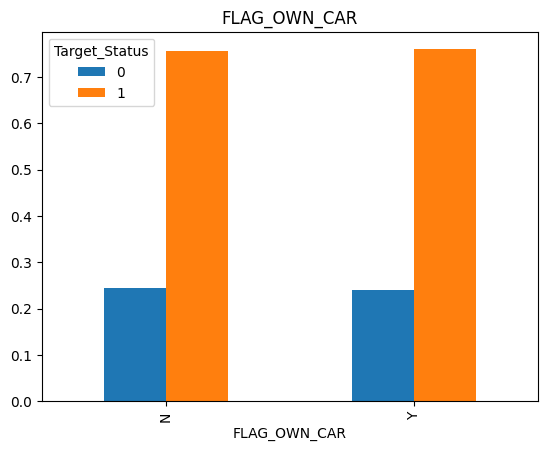

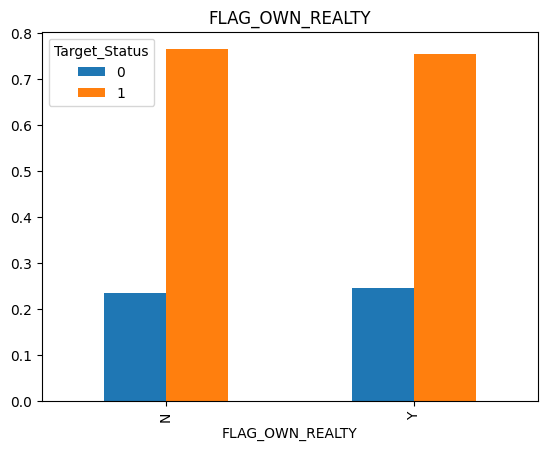

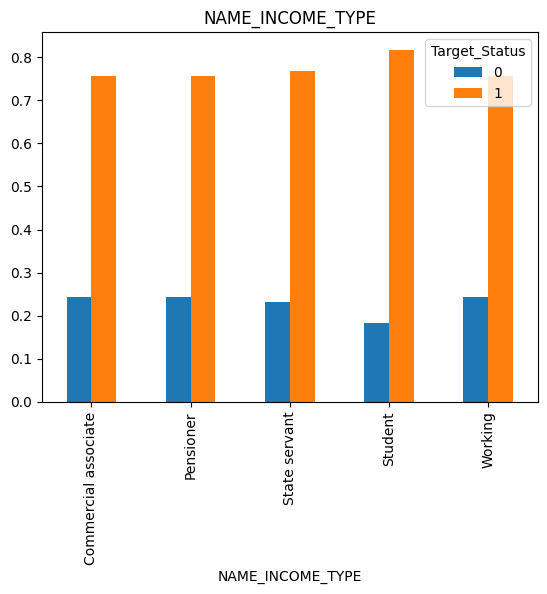

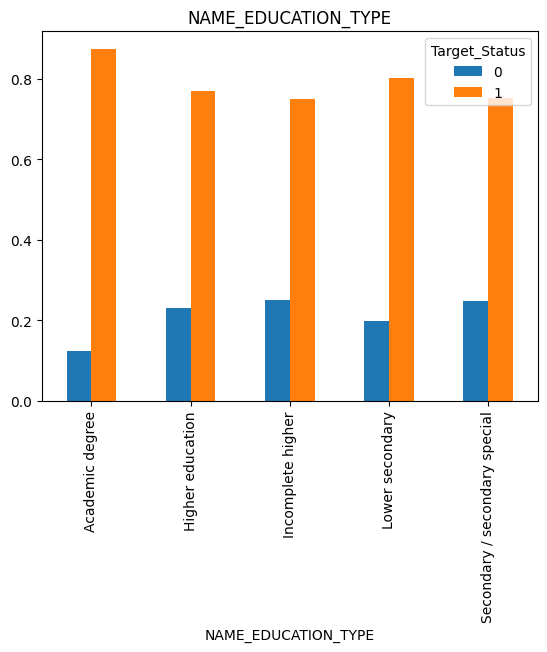

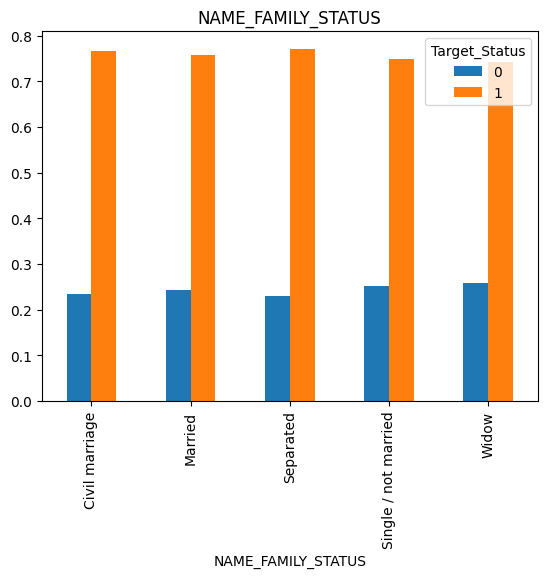

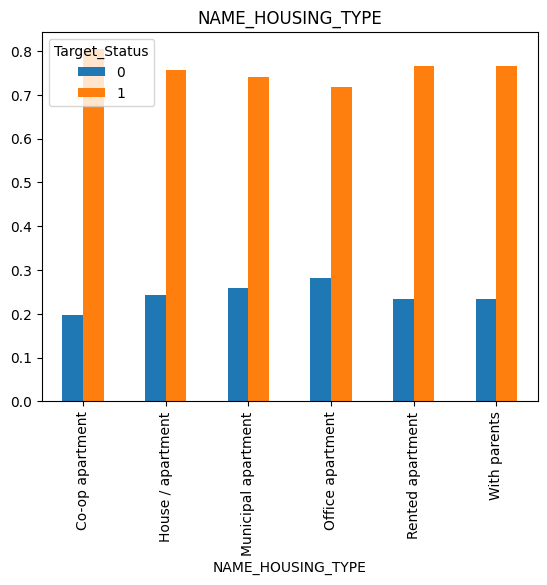

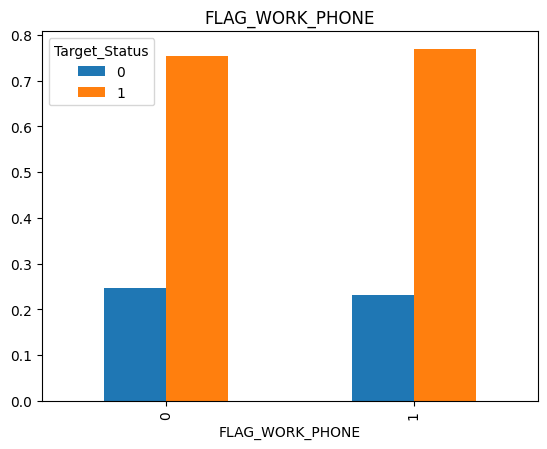

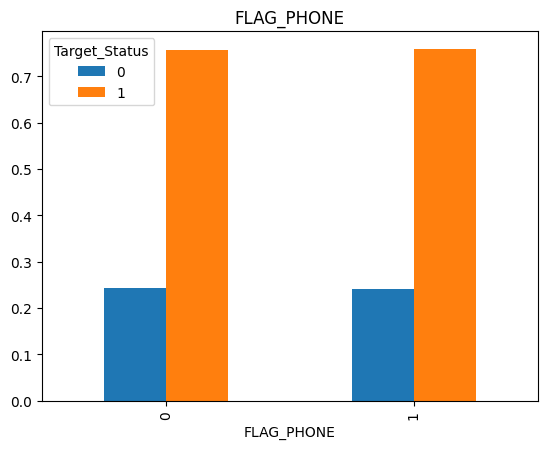

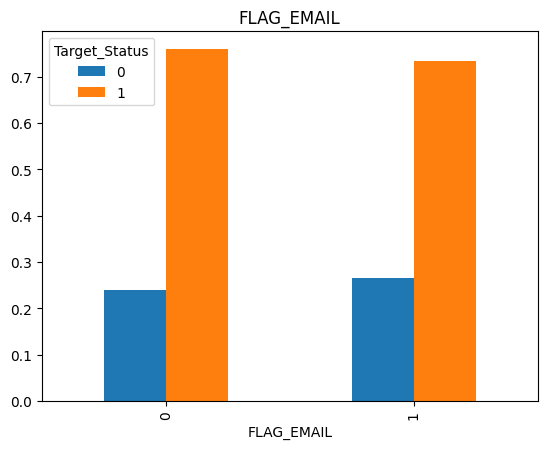

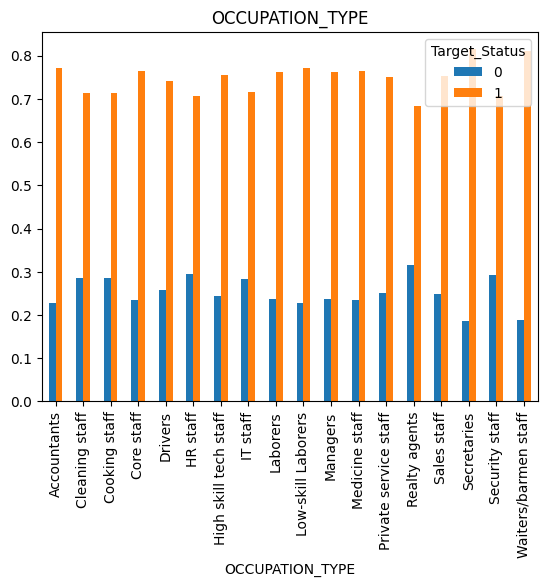

In [33]:
# 이런 경우에는 비율 데이터를 plot으로 그리면 데이터 분포 이해에 도움.

plt.figure(figsize=(30,30))
#plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_columns:
    pd.crosstab(df[column_name], df[target_column], normalize="index").plot.bar()
    plt.title(column_name)
plt.show()

##### 카이제곱 검정 (chisqaure-test)
*   카이제곱 검정은 두 범주형 변수에 대한 분석 방법.
*   예를 들어, 성별에 따른 선호 영화 장르 비교 문제.
*   본 실습에서는 독립 변수중의 categorical column data와 y(target_status) 간의 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/카이제곱_검정



##### 카이제곱 검정 추가 설명 : 3가지 유형
1.   적합도 검정 (Goodness of fit)
  - 변수 1개
  - 기존에 알려준 기준이 존재하는 검정
  - 예시) 상자 안에 공 3개가 같은 비율로 알려져 있음. 공 100개를 뽑았을 때, 각 색의 비율이 구해짐. -> 기존에 알려진 공 비율 분포를 따르는지 검정
  - 귀무가설 : 변수 X의 관측분포와 기대 분포가 동일
  - 대립가설 : 변수 X의 관측분포와 기대분포가 동일

2.   독립성 검정 (Test of independence)
  - 변수 2개
  - 범주형 두 변수가 서로 연관되어 있는지 여부를 검정
  - 예시) 성별과 흡연 여부 관계를 알고 싶어서 200명을 추출하여 조사한 경우.
  - 귀무가설 : 변수 X와 Y는 서로 독립
  - 대립가설 : 변수 X와 Y는 서로 독립이 아님
3.   동질성 검정 (Test of Homogeneity)
  - 변수 2개
  - 범주형 두 변수의 관계를 알기 위한 검정은 아님
  - 각 그룹들이 동질한지 알고 싶은 검정
  - 예시) 남자와 여자 흡연율 차이가 있는지 흡연율을 조사한 후, 두 그룹의 흡연율이 같은지 여부를 검정
  - 귀무가설 : 각 그룹의 확률분포가 동일
  - 대립가설 : 각 그룹의 확률분포가 동일하지 않음




In [34]:
list_meaningful_column_by_chi = []
for column_name in list_categorical_columns:
  ##### to do #####
  statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column], df[column_name]))
  if pvalue <= 0.05:
    list_meaningful_column_by_chi.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all categorical columns : ", len(list_categorical_columns))
print("selected columns by chi : ", len(list_meaningful_column_by_chi), list_meaningful_column_by_chi)

CODE_GENDER ,  9.14917437672138e-06 ,  0.9975865942019964
FLAG_OWN_CAR ,  0.5098662708631283 ,  0.4751967521310614
FLAG_OWN_REALTY ,  4.977225226185185 ,  0.025683144705680533
NAME_INCOME_TYPE ,  2.01113474585598 ,  0.7337107708524153
NAME_EDUCATION_TYPE ,  18.572087173370093 ,  0.0009536101652285508
NAME_FAMILY_STATUS ,  7.550663604106124 ,  0.10949588140271563
NAME_HOUSING_TYPE ,  6.989183690226566 ,  0.22144597438992644
FLAG_WORK_PHONE ,  8.161893932932294 ,  0.004277967441616775
FLAG_PHONE ,  0.141973825352162 ,  0.7063265945457923
FLAG_EMAIL ,  10.15955131332863 ,  0.0014355555483766811
OCCUPATION_TYPE ,  37.75898732078343 ,  0.00265220666581643
all categorical columns :  11
selected columns by chi :  5 ['FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE']


##### Insight
1.   y(종속 변수)와 categorical data 11개 중 5개만이 유의미한 관계를 갖음
2.   유의미한 관계를 갖는 categorical data를 feature selection하여 추후 ML 학습시 활용



#### 2) Numeric Data Analysis

##### 불필요한 컬럼 확인

In [35]:
#### to do ####
df[list_numeric_columns].nunique().sort_values()

CNT_CHILDREN           9
CNT_FAM_MEMBERS       10
MONTHS_BALANCE        61
AMT_INCOME_TOTAL     265
DAYS_EMPLOYED       3640
DAYS_BIRTH          7183
dtype: int64

In [36]:
df[list_numeric_columns].describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,MONTHS_BALANCE
count,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000
mean,0.430315,1.866857e+05,-15975.173382,59262.935568,2.198453,-5.831802
std,0.742367,1.017892e+05,4200.549944,137651.334859,0.911686,11.326494
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.000000,-60.000000
25%,0.000000,1.215000e+05,-19438.000000,-3153.000000,2.000000,-6.000000
50%,0.000000,1.575000e+05,-15563.000000,-1552.000000,2.000000,0.000000
75%,1.000000,2.250000e+05,-12462.000000,-408.000000,3.000000,0.000000
max,19.000000,1.575000e+06,-7489.000000,365243.000000,20.000000,0.000000


##### Column별 분포 확인

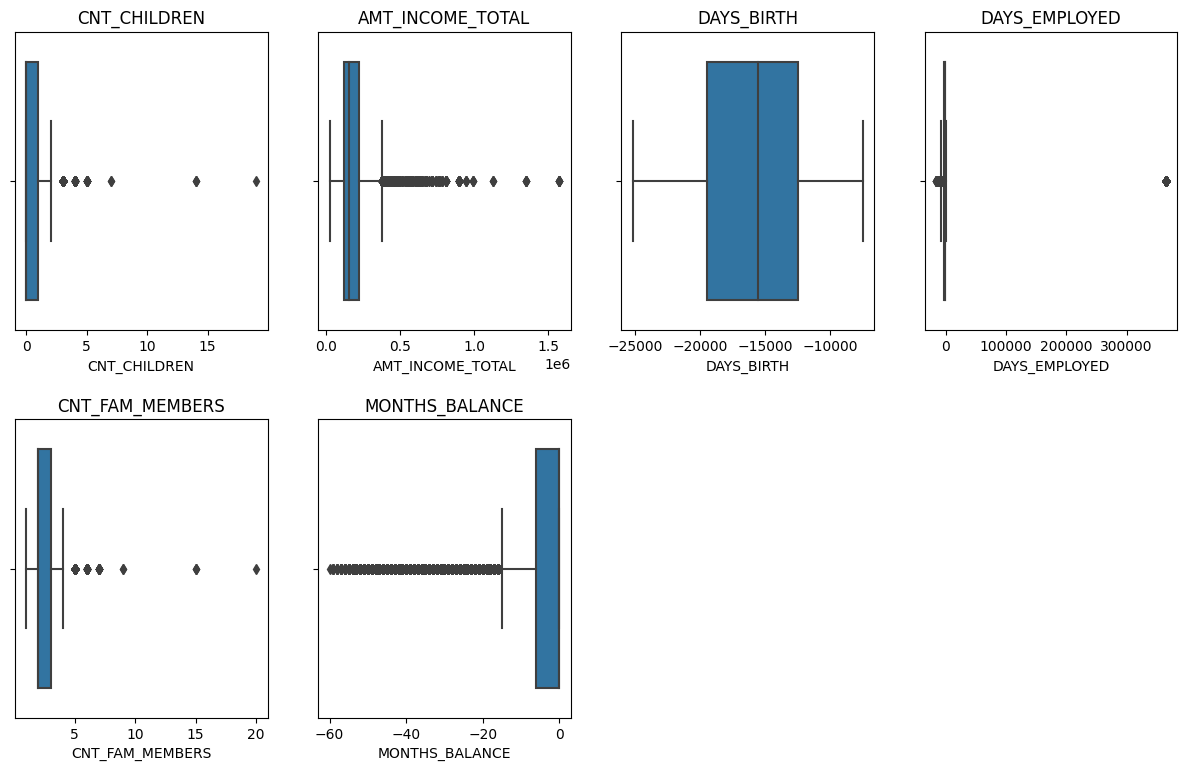

In [37]:
# numeric column 별 분포 확인
plt.figure(figsize=(15,7))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(2,4,x)
    x = x+1
    sns.boxplot(x=column_name, data=df)
    plt.title(column_name)
plt.show()

In [38]:
for column_name in list_numeric_columns:
  print(column_name, "skew : ", skew(df[column_name]), "kur : ", kurtosis(df[column_name]) )

# 추후 scaling을 활용한 feature preprocessing의 필요성 확인

CNT_CHILDREN skew :  2.5692764853112635 kur :  22.55917511845248
AMT_INCOME_TOTAL skew :  2.738897180151655 kur :  17.595506164509793
DAYS_BIRTH skew :  -0.18422206947290823 kur :  -1.045664746406706
DAYS_EMPLOYED skew :  1.7723702515885982 kur :  1.1430772697054437
CNT_FAM_MEMBERS skew :  1.298542476962789 kur :  8.187407769180325
MONTHS_BALANCE skew :  -2.1378871685624534 kur :  3.918957344284352


##### Correlation Analysis

<AxesSubplot: >

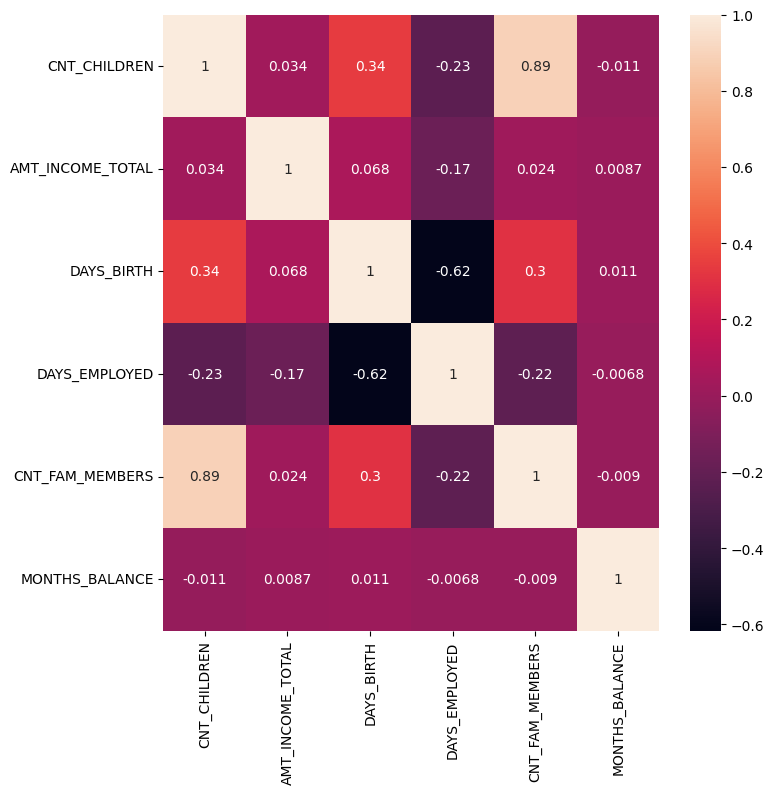

In [39]:
#### to do ####
df_corr = df[list_numeric_columns].corr()
plt.figure(figsize=(8,8))

sns.heatmap(df_corr, annot=True)

In [40]:
# CNT_FAM_MEMBERS와 CNT_CHILDREN이 상관관계가 높음
# 상식적으로 두개는 상관관계가 높을 것이라 판단됨

# 너무 높은 correlation을 갖는 데이터를 삭제. 단, 해당 correlation값을 신뢰할 수 있는지 확인필요
# 기준은 절대값 0.85 이상

#### to do ####
index_corr_over_85 = np.where((abs(df_corr)>0.85) & (df_corr != 1))
index_corr_over_85

(array([0, 4]), array([4, 0]))

In [41]:
# correlation이 0.85 이상인 경우의 pvalue 검정
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

statistic, pvalue = stats.pearsonr(df.loc[:,"CNT_FAM_MEMBERS"], df.loc[:,"CNT_CHILDREN"])
print(statistic)
print(pvalue)

0.8891141560147356
0.0


##### VIF Analysis
-   일반적으로는는 10이상인인 경우 다중공선성이이 있다고 가정
-   high correlation 컬럼을 제거하기 전에 한 번 더 검정을 진행 (doublecheck, 개인의 판단에 따라서 진행하지 않아도됨)

In [42]:
# caculate_vif function
#### to do ####
def caculate_vif(df_target):
  vif = pd.DataFrame()
  vif["VIF_Factor"] = [variance_inflation_factor(df_target.values, i) for i in range(df_target.shape[1])]
  vif["Feature"] = df_target.columns
  return vif

df_vif = df[list_numeric_columns].copy()

In [43]:
caculate_vif(df[list_numeric_columns])

,VIF_Factor,Feature
0,5.501891,CNT_CHILDREN
1,4.177863,AMT_INCOME_TOTAL
2,13.927450,DAYS_BIRTH
3,1.814530,DAYS_EMPLOYED
4,20.422667,CNT_FAM_MEMBERS
5,1.259641,MONTHS_BALANCE


In [44]:
caculate_vif(df[list_numeric_columns].drop("CNT_FAM_MEMBERS", axis=1))

,VIF_Factor,Feature
0,1.317477,CNT_CHILDREN
1,4.030542,AMT_INCOME_TOTAL
2,5.406126,DAYS_BIRTH
3,1.665757,DAYS_EMPLOYED
4,1.256456,MONTHS_BALANCE


In [45]:
list_numeric_feature_by_vif = list_numeric_columns.copy()
list_numeric_feature_by_vif.remove("CNT_FAM_MEMBERS")

In [46]:
list_numeric_feature_by_vif

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'MONTHS_BALANCE']

##### Target Column과 numeric Column 관계 분포 확인

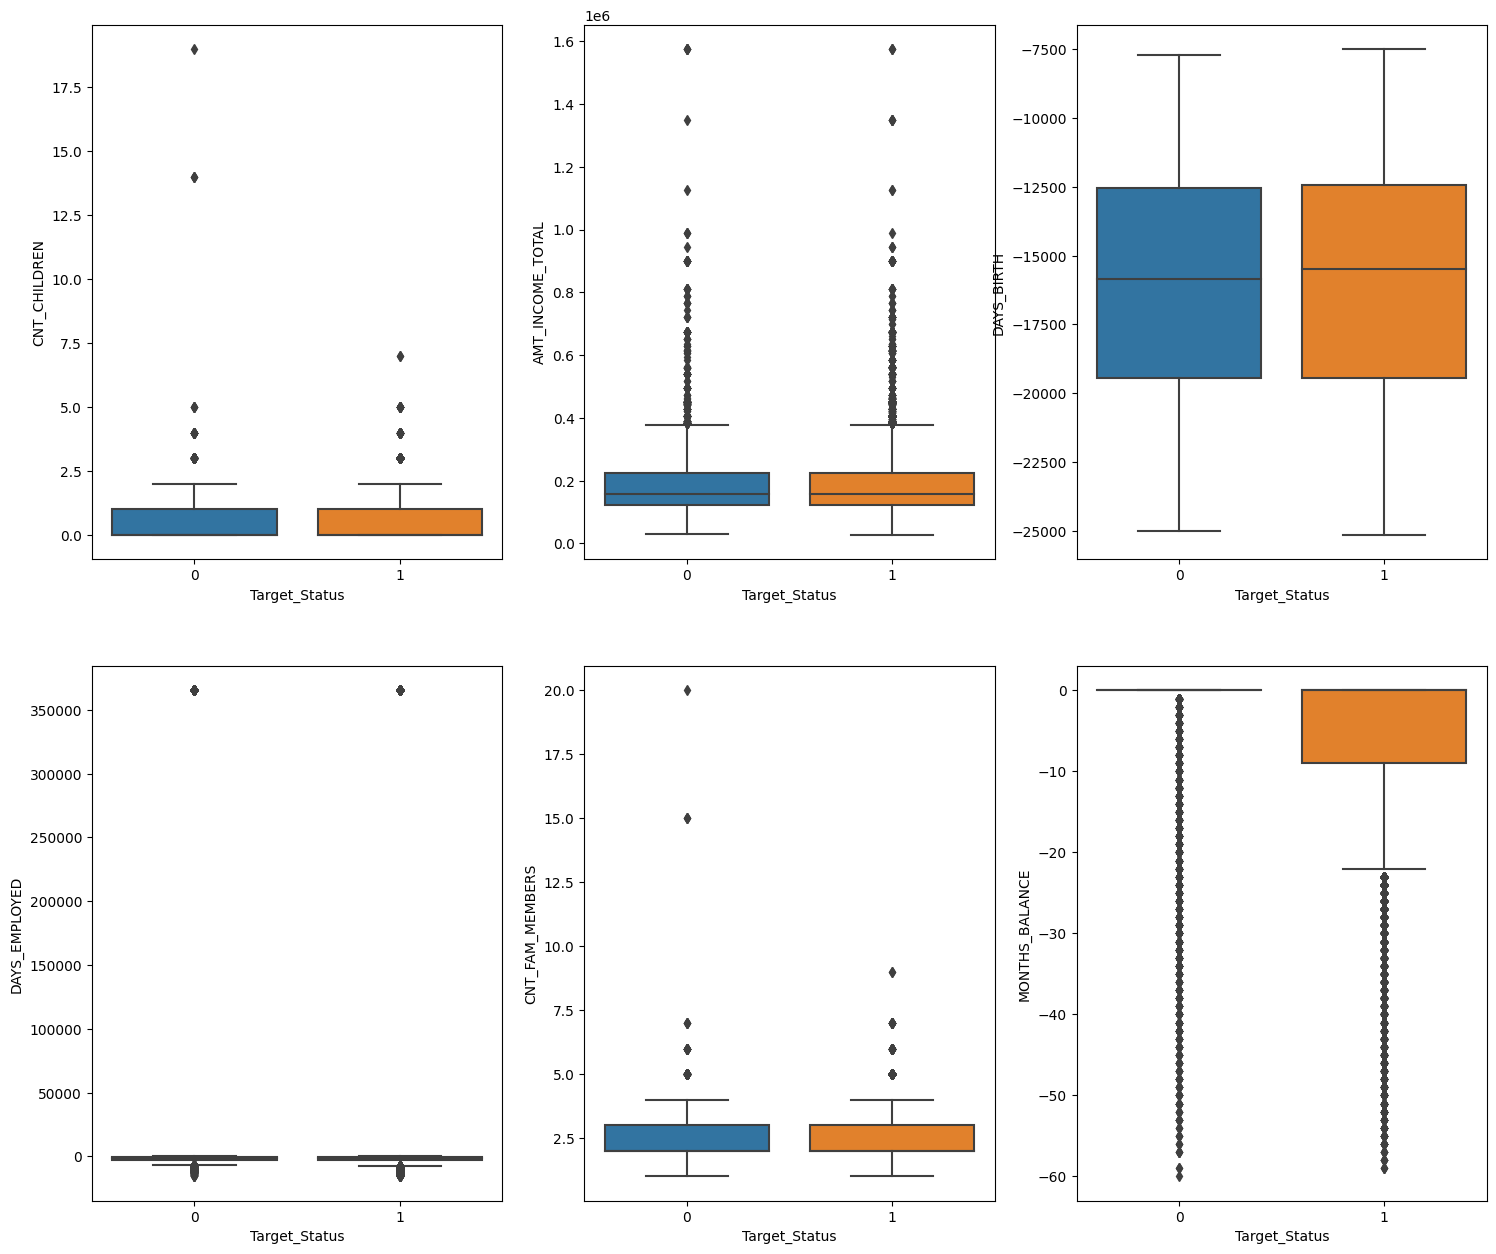

In [47]:
plt.figure(figsize=(18,12))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(2,3,x)
    x = x + 1
    sns.boxplot(data=df,x=target_column,y=column_name)
plt.show()

# month_balance 차이가 보임

##### 일원분산분석 (ANOVA)
*   카테고리별 numeric data 분포 차이를 검증
*   전제 : 정규성, 등분산성, 독립성 (만족하지 않으면 해당 검정을 신뢰할 수 없음)
*   본 실습에서는 target_status 에 따른 numeric column data 분포 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/분산_분석#일원분산분석(one-way_ANOVA)





정규성 검정
*   귀무가설 : 모집단의 분포는 정규 분포이다
*   검정 방법 : Shpiro-Wilks Test, qqplot
*   p-value < 0.05이면, 귀무가설 기각 (기각하지 못하여야 정규성을 만족)

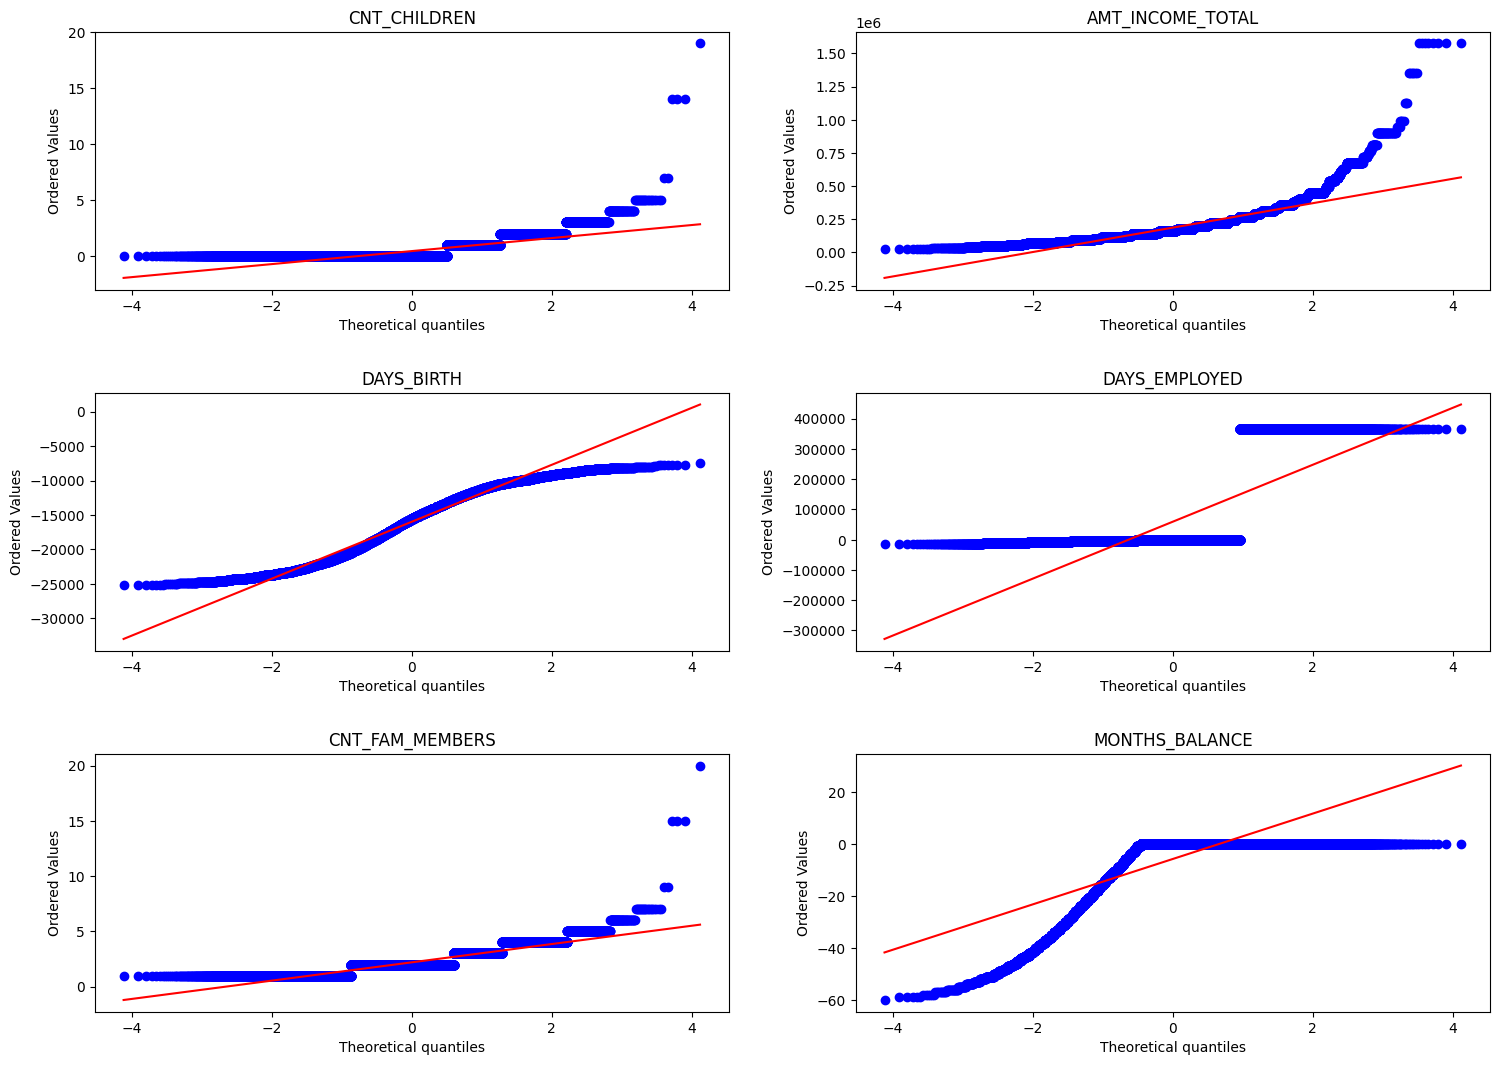

In [48]:
# numeric column 정규성 확인
plt.figure(figsize=(18,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(3,2,x)
    x = x+1
    stats.probplot(df[column_name], dist=stats.norm, plot=plt)
    plt.title(column_name)
plt.show()

In [49]:
#### to do ####
list_column_normality = []
for column_name in list_numeric_columns:
  statistic, pvalue = stats.shapiro(df[column_name])
  if pvalue >= 0.05:
    list_column_normality.append(column_name)
  print(column_name, ", statistic : ", statistic, ", pvalue : ", pvalue)

print("정규성 만족하는 column 수 : ",len(list_column_normality))

CNT_CHILDREN , statistic :  0.6153078079223633 , pvalue :  0.0
AMT_INCOME_TOTAL , statistic :  0.8168818354606628 , pvalue :  0.0
DAYS_BIRTH , statistic :  0.9663041234016418 , pvalue :  0.0
DAYS_EMPLOYED , statistic :  0.46614354848861694 , pvalue :  0.0
CNT_FAM_MEMBERS , statistic :  0.8236287832260132 , pvalue :  0.0
MONTHS_BALANCE , statistic :  0.5924310684204102 , pvalue :  0.0
정규성 만족하는 column 수 :  0


p-value may not be accurate for N > 5000.


정규성 만족하지 못함
*   정규성을 만족하지 못하므로, 등분산성 검정이 필요가 없음 (등분산성은 정규성을 전제)
*   일원분산분석을 통한 numeric data 검정 불가

##### 크루스칼 왈리스 검정 Kruskall-Wallis test (비모수 검정)
*   비모수 검정이기 때문에 정규성/등분산성을 만족하지 않아도됨
*   단, 비모수 검정이기 때문에 검정 결과 신뢰도가 모수 검정보다 떨어짐

In [50]:
list_target_unique = df[target_column].unique()
list_meaningful_column_by_kruskall = []

for column_name in list_numeric_columns:
  list_by_quality_value = []
  for quality_value in list_target_unique:
      df_tmp = df[df[target_column] == quality_value][column_name].dropna()
      list_by_quality_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_quality_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all numerical columns : ", len(list_numeric_columns))
print("selected columns by kruskal : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

CNT_CHILDREN ,  0.9337989725891732 ,  0.33387770621591706
AMT_INCOME_TOTAL ,  0.5387857888480218 ,  0.46293637094856877
DAYS_BIRTH ,  2.1336943086384164 ,  0.1440931072120902
DAYS_EMPLOYED ,  25.523534603497747 ,  4.370195260220316e-07
CNT_FAM_MEMBERS ,  0.9386094371351926 ,  0.33263571559306976
MONTHS_BALANCE ,  945.4711171201508 ,  1.280009852962771e-207
all numerical columns :  6
selected columns by kruskal :  2 ['DAYS_EMPLOYED', 'MONTHS_BALANCE']


##### Insight
1.   y(종속 변수)와 numerical data는 2개만이 유의미한 관계를 갖음 (크루스칼 왈리스 검정). (개인마다 다른 의사결정이 다를 수 있음, 실험을 통한 최적화 필요)
2.   상관관계가 매우 높으면서 VIF도 높은 변수가 존재하여, 데이터를 제거할 예정 ("CNT_FAM_MEMBERS")


## 3. Data Processing 2

### 3-1 Feature Selection
*   카이제곱 검정을 통과한 categorical 선택
*   kruskall 검정 통과한 numerical 선택
*   correlation에서 상관관계가 높다고 판단한 numericla data 제거



In [51]:
list_selected_numerical = list_meaningful_column_by_kruskall.copy()

In [52]:
df_fs = df[list_meaningful_column_by_chi + list_selected_numerical + [target_column]]
df_fs.head(2)

,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,FLAG_WORK_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,DAYS_EMPLOYED,MONTHS_BALANCE,Target_Status
0,Y,Higher education,1,0,NaN,-4542,0,1
1,Y,Higher education,1,0,NaN,-4542,0,1


### 3-2 Missing Values

In [53]:
df_fs.isna().sum()

FLAG_OWN_REALTY            0
NAME_EDUCATION_TYPE        0
FLAG_WORK_PHONE            0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
DAYS_EMPLOYED              0
MONTHS_BALANCE             0
Target_Status              0
dtype: int64

In [54]:
df["OCCUPATION_TYPE"]

0                   NaN
1                   NaN
2        Security staff
3           Sales staff
4           Sales staff
              ...      
36452          Managers
36453    Medicine staff
36454    Medicine staff
36455       Sales staff
36456          Laborers
Name: OCCUPATION_TYPE, Length: 36457, dtype: object

In [55]:
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   FLAG_OWN_REALTY      36457 non-null  object
 1   NAME_EDUCATION_TYPE  36457 non-null  object
 2   FLAG_WORK_PHONE      36457 non-null  object
 3   FLAG_EMAIL           36457 non-null  object
 4   OCCUPATION_TYPE      25134 non-null  object
 5   DAYS_EMPLOYED        36457 non-null  int64 
 6   MONTHS_BALANCE       36457 non-null  int64 
 7   Target_Status        36457 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.5+ MB


In [56]:
df_fs.isna().sum()

FLAG_OWN_REALTY            0
NAME_EDUCATION_TYPE        0
FLAG_WORK_PHONE            0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
DAYS_EMPLOYED              0
MONTHS_BALANCE             0
Target_Status              0
dtype: int64

### 3-3 Feature Transformation

In [57]:
Y = df_fs[target_column]
X = df_fs.drop([target_column], axis=1)

In [58]:
Y

0        1
1        1
2        1
3        0
4        1
        ..
36452    0
36453    1
36454    1
36455    0
36456    0
Name: Target_Status, Length: 36457, dtype: object

##### Label Encoding

In [59]:
# object를 int64 형 변환만 완료하면 됨.
# astype('int64')를 쓰거나 아래 labelencoder를 쓰면됨. astype이 효율적이지만, 이번 실습에서는 LabelEncoder를 써보도록 진행.
le = LabelEncoder()
le.fit(Y)
Y_encoded = le.transform(Y)

In [60]:
Y_encoded

array([1, 1, 1, ..., 1, 0, 0])

In [61]:
type(Y_encoded[0])

numpy.int64

##### Feature Scaling
*   Standardization과 MinMaxScaling은 다른 것.
*   MinMaxScaling은 [0,1]로 값을 scaling 하는 것 (예 sklearn의 MinMaxScaler())
*   Standardization은 정규분포의 표준화를 활용하여 scaling하는 것 (예 sklearn의 StandardScaler())



In [62]:
list_categorical_columns = list(df_fs.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df_fs.select_dtypes(include=['float64','int64']).columns)
print(len(list_categorical_columns))
print(len(list_numeric_columns))

6
2


In [63]:
### to do ###
# minmaxscaling
scaler_minmax = MinMaxScaler()
X.loc[:, list_selected_numerical] = scaler_minmax.fit_transform(X[list_selected_numerical])
X.head(1)

,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,FLAG_WORK_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,DAYS_EMPLOYED,MONTHS_BALANCE
0,Y,Higher education,1,0,NaN,0.029324,1.0


##### One-hot Encoding for categorical column data

In [64]:
X_base = pd.get_dummies(X)
X_base.head(1)

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


,DAYS_EMPLOYED,MONTHS_BALANCE,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,FLAG_WORK_PHONE_0,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,0.029324,1.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3-4 Sampling
*   이번 실습에서는 한 가지 oversampling 기법과 combinedsampling 기법을 활용하고, 이를 활용하여 Model optimization 진행
*   SMOTE : Synthetic Minority Overf-sampling Technique. minority class에서 synthetic sampling을 생성하는 방법. 특정 minority class A에서 knn 기준으로 가까운 minority class Set K를 생성하고, A와 Set K 사이 간에 새로운 관측치를 생성하는 기법.
*   SMOTEENN : SMOTE + ENN



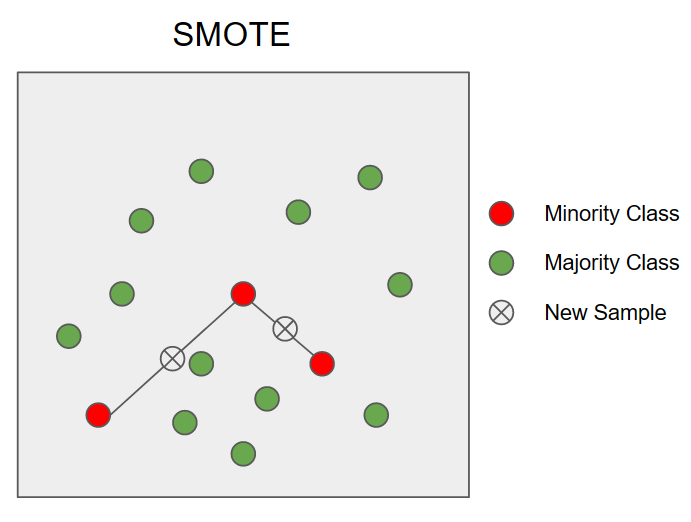

In [67]:
Image(path_lecture+"img/sampling.png")

In [65]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y_encoded, test_size=0.2, stratify=Y_encoded)

SMOTE

In [66]:
### to do ###
# smote oversampling

sm = SMOTE(random_state=random_state)
X_sm_sampling, y_sm_sampling = sm.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'After sampling for target label')

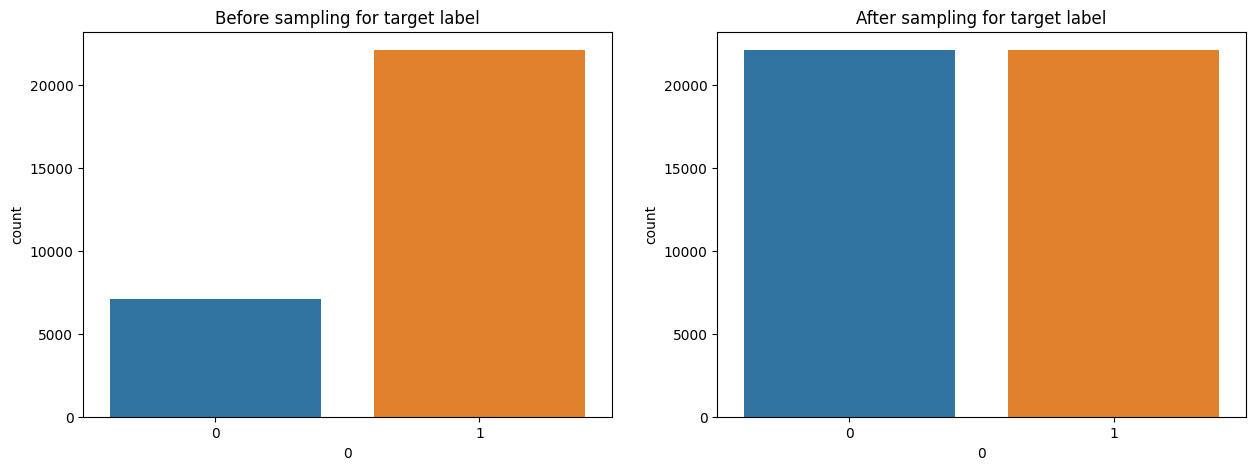

In [67]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
sns.countplot(data=pd.DataFrame(y_train), x=0)
plt.title("Before sampling for target label")

fig.add_subplot(122)
sns.countplot(data=pd.DataFrame(y_sm_sampling), x=0)
plt.title("After sampling for target label")

SMOTEENN

In [74]:
combined_sm = SMOTEENN(random_state=random_state)
X_csm_sampling, y_csm_sampling = combined_sm.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'After sampling for target label')

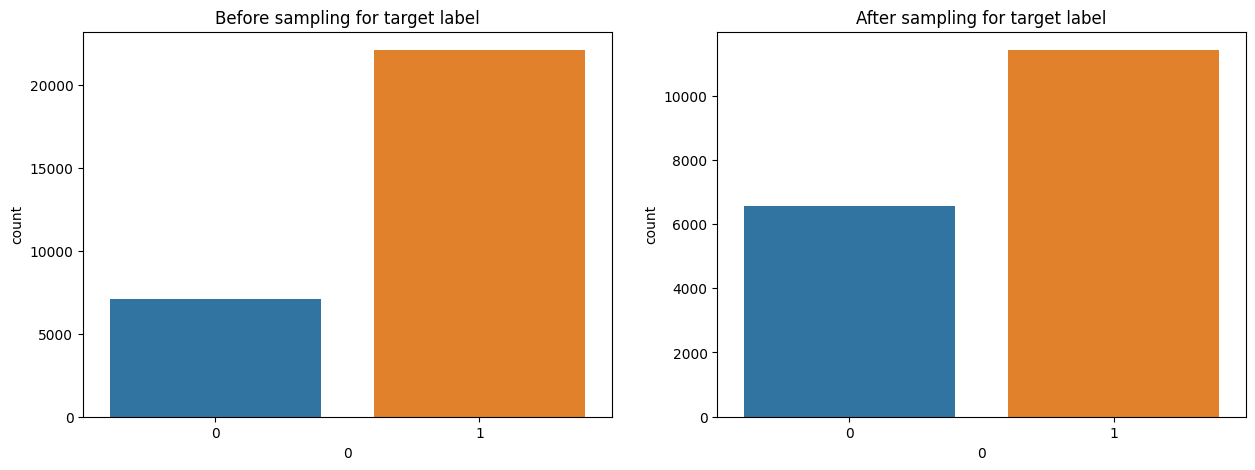

In [75]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
sns.countplot(data=pd.DataFrame(y_train), x=0)
plt.title("Before sampling for target label")

fig.add_subplot(122)
sns.countplot(data=pd.DataFrame(y_csm_sampling), x=0)
plt.title("After sampling for target label")

### 3-3 Summary
##### 최종 생성 Feature는 아래와 같은 특성을 가짐
1.   Feature Selection by Chi-test, correlation and kruskal-test
2.   Feature Transformation
3.   Sampling (oversampling, combiedsampling)

##### Feature 종류
1.   X_base, Y_encoded (No sampling, imbalanced data)
2.   X_sm_sampling, Y_sm_sampling (smote oversampling)
3.   X_csm_sampling, y_csm_sampling (smoteenn combinedsampling)

## 4. Model Analysis
1.   base model without sampling
2.   model optimization with base feature
3.   model optimization with smote oversampling
4.   model optimization with smoteenn combined sampling

In [76]:
list_model_type = []
list_model_best_params = []
list_model_f1_score = []
cv = 3
n_iter_randomsearch = 40

### 4-1. Base model without sampling

In [81]:
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_train, y_train)

3

In [77]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.create_experiment("credit_approval_ml")


'162836187436232346'

In [78]:
mlflow.set_experiment("credit_approval_ml")

<Experiment: artifact_location='mlflow-artifacts:/162836187436232346', creation_time=1705032529631, experiment_id='162836187436232346', last_update_time=1705032529631, lifecycle_stage='active', name='credit_approval_ml', tags={}>

In [79]:
mlflow.sklearn.autolog()

In [82]:
list_fold_result = []
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
  X_train_cv, X_test_cv = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
  y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
  rf_clf = MLPClassifier(hidden_layer_sizes=10)
  rf_clf.fit(X_train_cv, y_train_cv)
  y_prd_test = rf_clf.predict(X_test_cv)
  y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:,-1]
  prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average="macro")
  score_test = roc_auc_score(y_test_cv, y_prd_proba_test)
  print(i, " precision, recall, f1score : ", prf_score_test)
  print(i, " roc_auc_score : ", score_test)

  y_prd_validation = rf_clf.predict(X_validation)
  y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]
  prf_score_validation = precision_recall_fscore_support(y_validation, y_prd_validation, average="macro")
  score_validation = roc_auc_score(y_validation, y_prd_proba_validation)
  print("validation : precision, recall, f1score : ",prf_score_validation)
  print("validation : roc_auc_score : ",score_validation)
  list_fold_result.append(prf_score_validation[2])
  mlflow.log_param("feature_type", "base feature")

f1score_final = np.mean(list_fold_result)
print("average roc auc score : ",f1score_final)
list_model_type.append("Base model without sampling")
list_model_best_params.append({})
list_model_f1_score.append(f1score_final)

2024/01/12 13:09:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '021b86ecffab404fa3323f1132d95753', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/01/12 13:09:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/stayfoolish/miniforge3/envs/etl_cv/lib/python3.8/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling In

0  precision, recall, f1score :  (0.45558438055343997, 0.4993549856978721, 0.43207536788275924, None)
0  roc_auc_score :  0.5875532459392816
validation : precision, recall, f1score :  (0.5455503620199799, 0.5006106631367525, 0.4340517581572009, None)
validation : roc_auc_score :  0.573664005442315


2024/01/12 13:09:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/stayfoolish/miniforge3/envs/etl_cv/lib/python3.8/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


1  precision, recall, f1score :  (0.3787551440329218, 0.4998642226748133, 0.4309628328943518, None)
1  roc_auc_score :  0.5908801648453093
validation : precision, recall, f1score :  (0.8788751714677641, 0.5005656108597285, 0.4322209377278912, None)
validation : roc_auc_score :  0.5755059268318256


2024/01/12 13:09:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/stayfoolish/miniforge3/envs/etl_cv/lib/python3.8/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


2  precision, recall, f1score :  (0.6647706368011302, 0.5012904608937099, 0.4344322284570881, None)
2  roc_auc_score :  0.5768792999514751
validation : precision, recall, f1score :  (0.6788939206806641, 0.5006673880491873, 0.4327278759621365, None)
validation : roc_auc_score :  0.5790490836366853
average roc auc score :  0.43300019061574285


<AxesSubplot: >

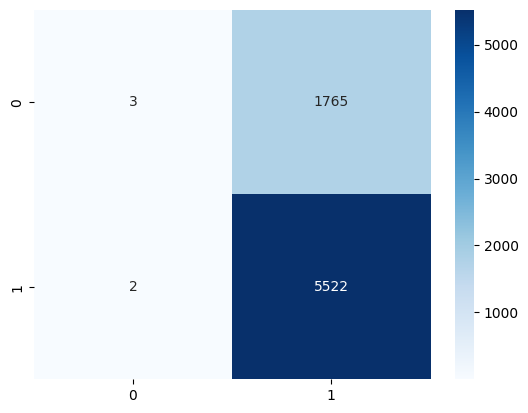

In [83]:
cm = pd.DataFrame(confusion_matrix(y_validation,y_prd_validation))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')

### 4-2. model optimization with base feature

In [84]:
def plot_roc_auc(y_true, y_prd_proba):
  fpr, tpr, _ = roc_curve(y_true,  y_prd_proba)
  auc = roc_auc_score(y_true, y_prd_proba)
  plt.figure(figsize=(7,7))
  plt.plot(fpr,tpr,label="auc="+str(auc))
  plt.legend(loc=4)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.show()

In [85]:
mlflow.end_run()

In [86]:
def model_learning_with_randomsearch(model, hyper_parameter, X, Y, feature_type="base_feature",metric="roc_auc"):
  with mlflow.start_run():
    #mlflow.sklearn.autolog()
    random_cv_opt = RandomizedSearchCV(estimator=model, param_distributions=hyper_parameter, n_iter=n_iter_randomsearch, cv = cv, random_state=random_state, scoring=metric, verbose=1)
    random_cv_opt.fit(X, Y)
    y_prd = random_cv_opt.predict(X_validation)
    mlflow.log_param("feature_type", feature_type)
    prf_score = precision_recall_fscore_support(y_validation, y_prd, average="macro")
    y_prd_proba = random_cv_opt.predict_proba(X_validation)[:,-1]
    score = roc_auc_score(y_validation, y_prd_proba)
    print('validation -> best model hyper-parameter : ', random_cv_opt.best_params_)
    print("validation -> precision, recall, f1score : ", prf_score)
    print("validation -> roc_auc_score : ", score)

    cm = pd.DataFrame(confusion_matrix(y_validation,y_prd))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')

  return random_cv_opt.best_params_, prf_score, prf_score[2]

The total space of parameters 32 is smaller than n_iter=40. Running 32 iterations. For exhaustive searches, use GridSearchCV.


Fitting 3 folds for each of 32 candidates, totalling 96 fits


2024/01/12 13:10:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/stayfoolish/miniforge3/envs/etl_cv/lib/python3.8/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/01/12 13:10:27 INFO mlflow.sklearn.utils: Logging the 5 best runs, 27 runs will be omitted.


validation -> best model hyper-parameter :  {'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'max_iter': 10000, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': 15, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'relu'}
validation -> precision, recall, f1score :  (0.7290854160944795, 0.5017080956484415, 0.43506304254526357, None)
validation -> roc_auc_score :  0.5972090421558252


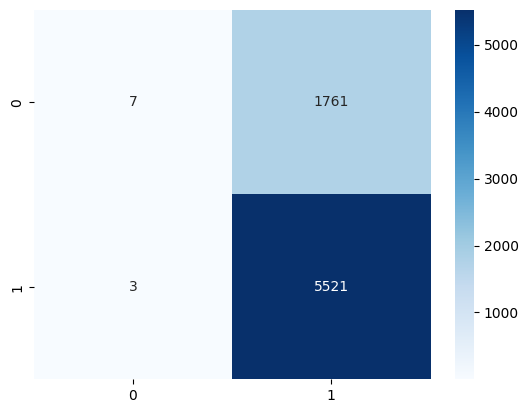

In [87]:
hyper_params_mlp = {
    'hidden_layer_sizes': [10, 15, 20, 25],
    'activation': ['tanh', 'relu'],
    'solver': ["sgd", "adam"],
    'learning_rate': ['constant'],
    'learning_rate_init': [0.001, 0.01],
    'power_t': [0.5],
    'alpha': [0.0001],
    'max_iter': [10000],
    'early_stopping': [True],
    'warm_start': [False]
              }

params, prf_score, score = model_learning_with_randomsearch(MLPClassifier(), hyper_params_mlp, X_base, Y_encoded, feature_type="base_feature")
list_model_type.append("model optimization with base feature")
list_model_best_params.append(params)
list_model_f1_score.append(score)

### 4-3. model optimization with smote oversampling

The total space of parameters 32 is smaller than n_iter=40. Running 32 iterations. For exhaustive searches, use GridSearchCV.


Fitting 3 folds for each of 32 candidates, totalling 96 fits


2024/01/12 13:12:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/stayfoolish/miniforge3/envs/etl_cv/lib/python3.8/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/01/12 13:12:16 INFO mlflow.sklearn.utils: Logging the 5 best runs, 27 runs will be omitted.


validation -> best model hyper-parameter :  {'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'max_iter': 10000, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': 20, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'relu'}
validation -> precision, recall, f1score :  (0.5571243570142238, 0.5732955494903358, 0.48235047290679167, None)
validation -> roc_auc_score :  0.5906003850740987


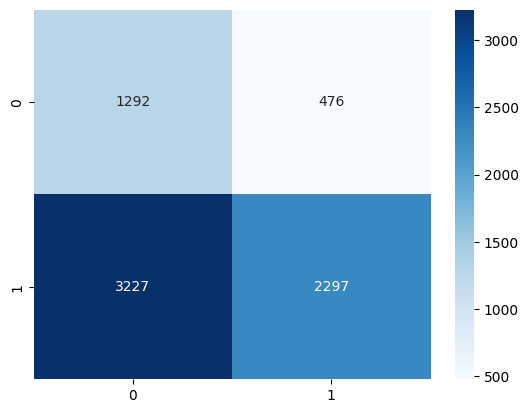

In [88]:
params, prf_score, score = model_learning_with_randomsearch(MLPClassifier(), hyper_params_mlp, X_sm_sampling, y_sm_sampling, feature_type="smote oversampling")
list_model_type.append("model optimization with smote oversampling")
list_model_best_params.append(params)
list_model_f1_score.append(score)

### 4-4. model optimization with smoteenn combined sampling

The total space of parameters 32 is smaller than n_iter=40. Running 32 iterations. For exhaustive searches, use GridSearchCV.


Fitting 3 folds for each of 32 candidates, totalling 96 fits


2024/01/12 13:13:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/stayfoolish/miniforge3/envs/etl_cv/lib/python3.8/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/01/12 13:13:10 INFO mlflow.sklearn.utils: Logging the 5 best runs, 27 runs will be omitted.


validation -> best model hyper-parameter :  {'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'max_iter': 10000, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': 20, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'relu'}
validation -> precision, recall, f1score :  (0.5325463601505398, 0.5338356935265611, 0.5330281748174264, None)
validation -> roc_auc_score :  0.5676801415296804


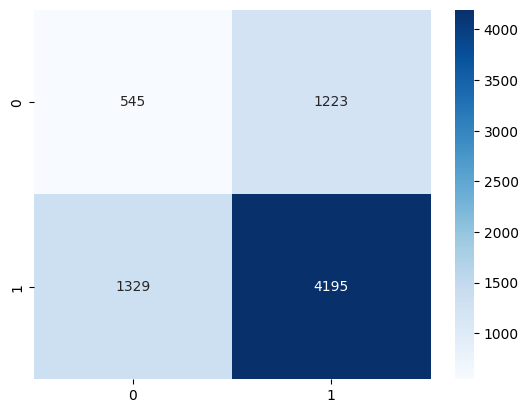

In [89]:
params, prf_score, score = model_learning_with_randomsearch(MLPClassifier(), hyper_params_mlp, X_csm_sampling, y_csm_sampling, feature_type="smoteenn combined sampling")
list_model_type.append("model optimization with smoteenn combined sampling")
list_model_best_params.append(params)
list_model_f1_score.append(score)

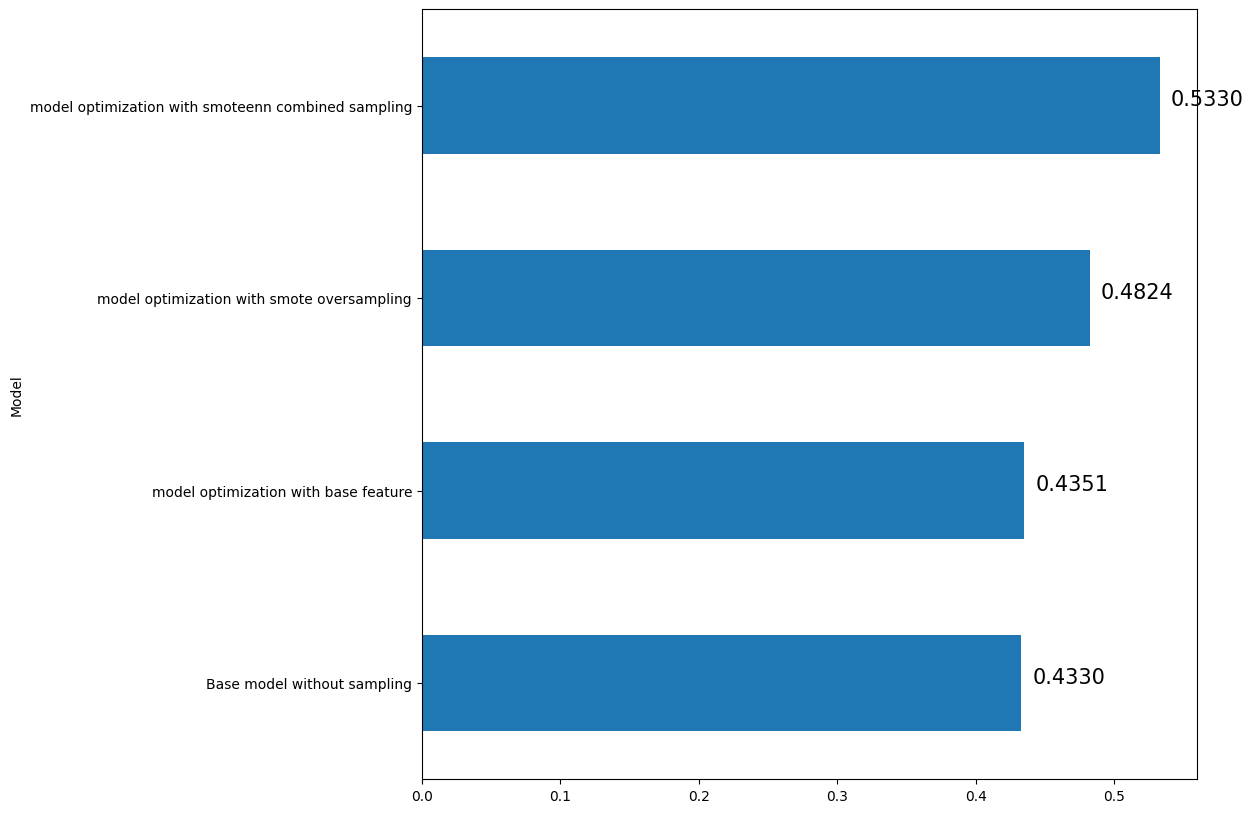

In [90]:
df_metric = pd.DataFrame({'Model':list_model_type, 'f1score_macro':list_model_f1_score})
ax = df_metric.plot.barh(x='Model', y='f1score_macro', rot=0, figsize=(10,10), legend=False)
for bar in ax.patches:
    ax.annotate(format(bar.get_width(), '.4f'),
                   (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                   size=15, xytext=(8, 0),
                   textcoords='offset points')

### 4.6 Model Serving

In [91]:
model_uri = "models:/credit_approval/Production"
loaded_model = mlflow.sklearn.load_model(model_uri)

In [92]:
loaded_model

MLPClassifier(early_stopping=True, hidden_layer_sizes=20,
              learning_rate_init=0.01, max_iter=10000)

In [93]:
y_prd_production = loaded_model.predict(X_validation)

In [94]:
y_prd_production
prf_score_production = precision_recall_fscore_support(y_validation, y_prd_production, average="macro")
score_production = roc_auc_score(y_validation, y_prd_production)

print(prf_score_production)
print(score_production)

(0.5325463601505398, 0.5338356935265611, 0.5330281748174264, None)
0.5338356935265612


In [ ]:
# mlflow models serve -m ./mlartifacts/162836187436232346/2a288e9bcc7b4505924949cfc101051f/artifacts/best_estimator -p 5001 --no-conda

In [95]:
import pandas as pd
import requests

# Define local host and endpoint url
host = "127.0.0.1"
url = f"http://{host}:5001/invocations"

# Create dictionary with pandas DataFrame in the split orientation
json_data = {"dataframe_split": X_validation[:10].to_dict(orient="split")}

# Score model
response = requests.post(url, json=json_data)
print(f"\nPyfunc 'predict_interval':\n${response.json()}")



Pyfunc 'predict_interval':
${'predictions': [1, 1, 0, 1, 1, 1, 1, 1, 1, 1]}


### 4.7 Model Analysis

##### Shapley Value
*   게임 이론에 근거해서 만들어진 값 (https://ko.wikipedia.org/wiki/게임이론)
*   하나의 특성에 대한 중요도를 알기위해 여러 특성들의 조합을 구성하고 해당 특성의 유무에 따른 변화를 분석해서 얻어낸 값
*.  Explainable AI
*   https://en.wikipedia.org/wiki/Shapley_value



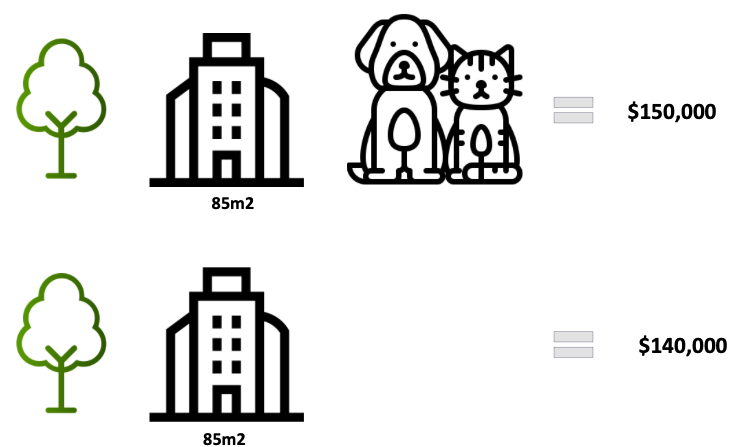

In [96]:
Image(path_lecture + "img/shapley_value.png")

In [97]:
mlp_final = MLPClassifier(**{'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'max_iter': 10000, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': 25, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'relu'})
mlp_final.fit(X_csm_sampling, y_csm_sampling)

2024/01/12 13:20:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f4191667c51849828d9cabc9dc807817', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2024/01/12 13:20:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/stayfoolish/miniforge3/envs/etl_cv/lib/python3.8/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


MLPClassifier(early_stopping=True, hidden_layer_sizes=25,
              learning_rate_init=0.01, max_iter=10000)

In [98]:
explainer = shap.Explainer(lambda x : mlp_final.predict_log_proba(x)[:,1], X_validation)
shap_values = explainer(X_validation)

Permutation explainer: 7293it [13:50,  8.68it/s]                          


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


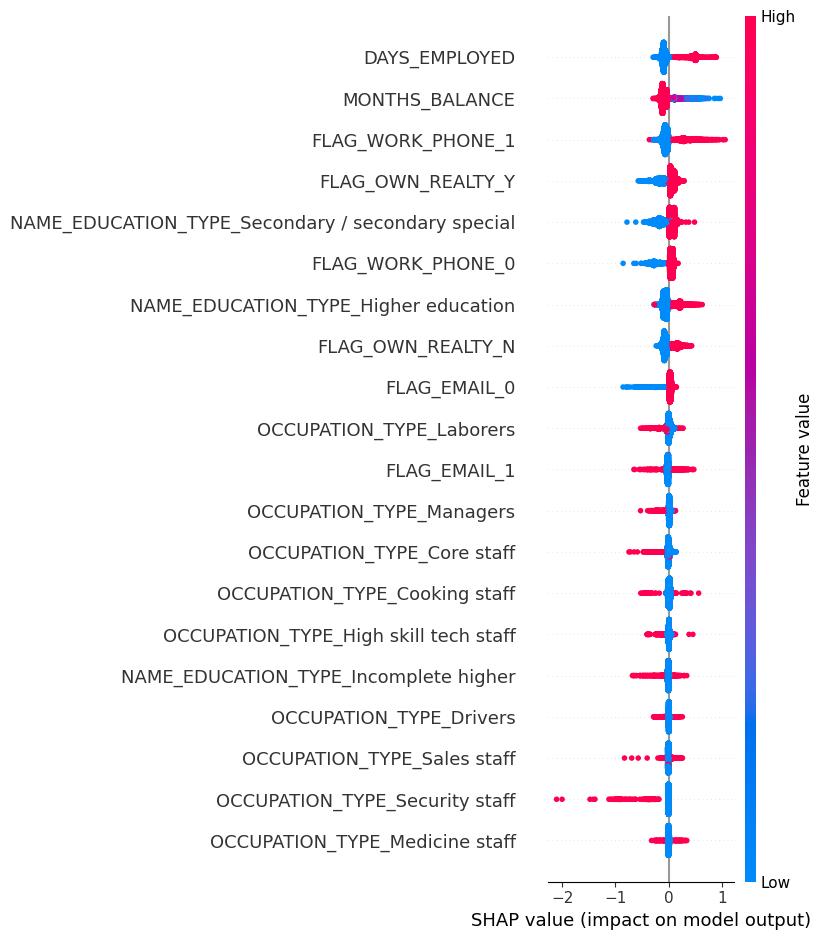

In [99]:
shap.summary_plot(shap_values, X_validation)